In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/', nb_path) 
sys.path.insert(0, nb_path)


Mounted at /content/mnt


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import tensorflow as tf
import string

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense,Softmax, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import warnings
warnings.filterwarnings(action='ignore')





# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    #print("x="+x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #print(year,month,day,hour)
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour) #20201130190653

def string2num(x):
    # (,)( )과 같은 불피요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

PATH='/content/mnt/MyDrive/Colab Notebooks/'
#PATH = '/content/'

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
import copy
id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42)) #15000,42 의 0배열 생성.
minnum=317
curuser=10000
errstrli=np.zeros((train_user_number,1),dtype="object")
templi=[]
tempstrli=[]
strli=[]
errli=np.empty((train_user_number,1),dtype="object")
sum=0
allnum=0
tempstr=""
for person_idx, err in tqdm(id_error):
    #print(person_idx)
    if (curuser==person_idx):
      templi.append(err)
      tempstr+=" "+str(err)
    else:
      errli[curuser-train_user_id_min][0]=np.array(templi)
      
      templi=[]
      templi.append(err)

      tempstrli.append(tempstr)
     # tempstrli=tempstrli[1:]
      strli.append(tempstrli)
      #print(curuser-train_user_id_min)
      errstrli[curuser-train_user_id_min]=copy.deepcopy(tempstrli)
      tempstrli=[]
      curuser=person_idx
      tempstr=""
      tempstr+=" "+str(err)

    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1  그래서 [사람idx,error type] 번째에 +=1 되는건데, errtype이 1~42니까 -1 해서 errtype의 min은 0번부터시작, person도 0번부터 시작
    error[person_idx - train_user_id_min,err - 1] += 1

errli[curuser-train_user_id_min][0]=np.array(templi) #마지막에는 한번 안 더해져서나와.
tempstrli.append(tempstr)
#tempstrli=tempstrli[1:]
print("tempstrl",tempstrli)
strli.append(tempstrli)
#newstrli=np.array(strli)
errstrli[curuser-train_user_id_min]=copy.deepcopy(tempstrli)
print("shape=",error.shape)
print("errli[0]=",errli[0])
print("errli.shape",errli[0].shape)
print("errli[0][0]",errli[0][0])




        

# 이말인즉슨, 1 row에 err type 0 이 몇회 발생 , 1이 몇회발생 ~~~


100%|██████████| 16554663/16554663 [00:59<00:00, 280237.79it/s]

tempstrl [' 4 4 11 12 5 4 16 26 4 15 4 16 4 15 16 15 16 15 4 16 4 15 16 4 4 15 16 4 26 4 15 16 15 4 16 4 15 4 16 4 15 12 11 13 12 3 7 6 14 14 14 14 16 4 26 4 15 4 16 4 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 16 15 4 16 4 15 4 16 4 15 12 11 5 16 4 26 4 15 16 15 16 15 16 15 16 4 26 4 15 4 16 4 15 16 4 4 15 12 11 4 16 26 4 15 16 15 16 15 16 4 4 15 16 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 16 15 16 15 16 15 16 15 16 15 12 11 4 16 26 4 15 16 4 4 15 4 16 4 15 16 15 3 13 12 7 6 14 14 14 14 14 14 4 16 26 4 15 16 4 4 15 16 4 4 15 16 15 11 12 5 4 16 26 4 15 4 16 4 15 16 4 4 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 16 4 4 15 16 15 4 4 12 11 5 4 16 26 4 15 16 4 4 15 16 15 16 4 4 15 16 4 4 15 16 4 26 4 15 16 15 16 15 16 4 4 15 12 11 16 4 26 4 15 16 4 4 15 16 15 16 4 4 15 4 16 26 4 15 4 16 4 4 4 15 16 4 4 15 16 4 4 15 6 4 4 11 12 5 3 13 12 6 7 14 14 14 14 16 4 26 4 15 16 4 4 15 16 15 16 4 4 15 16 4 26 4 15 16 4 4 15 16 4 4 15 16 15 11 12 5 16 4 26 4 15 16 15 16 15 16 4 4 15 4 16 26 4 15 16 4 4

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

problem = np.zeros(15000)
newproblem=np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0   문제가 하나도 없었던 사람은 0이야.
problem[train_prob.user_id.unique()-10000] = 1   
problem.shape
max=0
prob=train_prob[['user_id']].values

In [ ]:
#참고) 일별 합산 데이터 생성 코드      
import datetime
#train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime']=pd.to_datetime(train_err['time'])
#train_err['time']
#train_err['time'][0]
#print(train_err['time'])
train_err['datetime'] = train_err['time'].apply(make_datetime)


In [ ]:
#problem 개수
cntmy=[0]*15000

timeprob=np.zeros((15000,5,5),dtype="object") #15000명이있고, 한명당 최대 5번의 problem을 제기한적이 있다. 
#각 problem당, [[problem이 일어난시간],[problem이 일어난시간 +1시간 전까지 일어난 err 의 시간 리스트], 
#                [해당 errtype들 리스트], [해당 errcode들 리스트], [해당 err의 fwver 리스트]
#               ]

train_prob['datetime'] = train_prob['time'].apply(make_datetime)
id_probl = train_prob[['user_id','datetime']].values
id_errtime=train_err[['user_id','datetime','fwver','errtype','errcode']].values



In [ ]:

curuser=10000
first=0
last=0
cnt=0
idarr=[]
for uid,dtime,fw,errty,errco in tqdm(id_errtime):
    if (curuser==uid):
        last=cnt
    else:
        li=[]
        li.append(first)
        li.append(last)
        idarr.append(li)
        first=cnt
        curuser=uid
    cnt+=1
li=[]
li.append(first)
li.append(last)
idarr.append(li)

100%|██████████| 16554663/16554663 [00:22<00:00, 743986.36it/s]


In [ ]:
idarr #[0,316], [317,2681]
print(id_errtime[0],id_errtime[316],id_errtime[317],id_errtime[2681],id_errtime[2682])
#위의 코드는 이것과같이 userid 0번(실제론 uid==10000 인 사람)이 train_err.csv의 몇번째 index부터 몇번째 index까지 있는지

#idarr의 0번째항은 [0,316]이야. 즉 id_errtime[0]~id_errtime[316]까지는 모두 userid==10000의 data
# 1번째항은 [317,2681] 이니까 즉 id_errtime 317  ~~ 2681 까지는 모두 userid == 10001의 data인거

[10000 Timestamp('2020-11-01 02:00:00') '05.15.2138' 15 '1'] [10000 Timestamp('2020-11-30 21:00:00') '05.15.2138' 15 '1'] [10001 Timestamp('2020-11-01 02:00:00') '04.33.1185' 15 '1'] [10001 Timestamp('2020-11-30 22:00:00') '04.33.1261' 31 '0'] [10002 Timestamp('2020-11-01 03:00:00') '05.15.2138' 11 '1']


In [ ]:
cnt=0
cntmy=[0]*15000 #cntmy는 problem이 한명당 최대 5번까지 있을 수 있으니까, 해당 user가 처음으로 문제가 발견되었을 땐
#timeprob[userid][0] 번째에 넣어야하고, 2번째로 문제제기 했을땐 timeprob[userid][1] 번째에 넣어야 하고, 또 발견되면 2번째에 넣어야하고
#하기 때문에 필요함

for person_idx, timeid in tqdm(id_probl):
    cntmy[person_idx-10000]+=1
    cnt+=1
    #print(person_idx,timeid)
    tili=[]#timelist
    tyli=[]#typelist
    coli=[]#codelist
    fwli=[]#fwverlist
    first,last =idarr[person_idx-10000] #위에서 만든 idarr로 어디서부터 어디까지가 해당 user인지 알 수 있어
    for i in range(first,last+1):
        uid,dtime,fw,errty,errco = id_errtime[i]
        if(dtime< timeid+datetime.timedelta(hours=2)): # 문제가 제기된 시간 +2시간 이내의 모든 errtype모음 왜 1시간이냐구? 데이터 불러올때 분이랑 초를 다 날려먹었기때문
            tili.append(dtime)
            tyli.append(errty)
            coli.append(errco)
            fwli.append(fw)
    tim=[]
    tim.append(timeid)
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,0]=tim # 0번째는 그 problem시간
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,1]=tili#err시간
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,2]=tyli#errtype
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,3]=coli#errcode
    timeprob[person_idx-10000,cntmy[person_idx-10000]-1,4]=fwli#firmware


#print(tim,tili,tyli,coli)
    

100%|██████████| 5429/5429 [00:49<00:00, 108.80it/s]


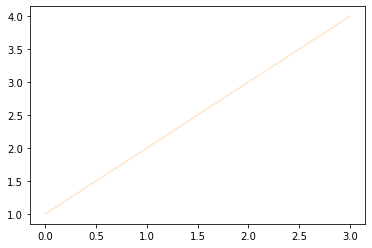

['05.15.2138' '04.33.1185' '04.33.1261' '04.22.1750' '04.22.1778'
 '04.16.3553' '04.33.1149' '04.16.3571' '05.66.3237' '05.66.3571'
 '03.11.1149' '04.22.1684' '03.11.1167' '04.82.1684' '04.82.1778'
 '04.33.1171' '04.73.2237' '10' '04.82.1730' '04.73.2571' '8.5.3'
 '04.22.1666' '03.11.1141' '05.15.2120' '04.33.1125' '04.16.3439'
 '04.22.1442' '04.33.1095' '04.16.3569' '05.15.2090' '05.15.3104'
 '05.15.2122' '04.22.1656' '04.16.2641' '05.15.2114' '04.16.3345'
 '05.15.2092']


In [ ]:
import itertools #이게 색깔 다양하게 만들어내는 코드
a=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] #이렇게 RGB는 (0~1,0~1,0~1) 의 튜플? 로 표현해야하는데 
npr=itertools.permutations(a,3) #이 permutation으로 하면 990개 색깔을 만들어낼 수 있어.
ac=list(npr)
#print(len(ac)) 990개 색깔
plt.plot([1,2,3,4],c=ac[989]) # 이 color에 RGB값을 넣어줄거야
plt.show()

print(train_err.fwver.unique())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


13476
13476
13476
13476
13476
13476
13476
13476
13476


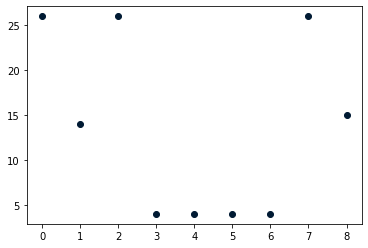

In [ ]:
cnt=0
cindex=0
fwstr="05.15.2114"
for uid in range(15000):
    cnt+=1
    for j in range(5):
        plotli=[]
        if (type(timeprob[uid][j][0]) == type(0)):#데이터없을때
            if (j !=0):
                break
            first,last=idarr[uid]
            for i in range(first,last+1):
                usid,dtime,fw,erty,errco=id_errtime[i]
                if (fw==fwstr):
                    print(uid)
                    plotli.append(erty)
            if (len(plotli)==0):
                break
            else:
                if (len(plotli)>30):
                    break
                t1=np.arange(0,len(plotli))
                plt.scatter(t1,plotli,c=ac[cindex%990])
                cindex+=1
            break
        
plt.show()

In [ ]:
cnt=0
cindex=0
for uid in range(15000):
    cnt+=1
    for j in range(5):
        if (type(timeprob[uid][j][0]) == type(0)):#데이터없을때
            break
        else:
            #t1=np.arange(0,len(timeprod[uid][j][2])) #2: errtype, 3: errcode 4: fwver
            plotli=[] #errtype들을 담아줄 리스트
            for fw in range(len(timeprob[uid][j][4])) :
                if ( timeprob[uid][j][4][fw] == fwstr): 
                    plotli.append(timeprob[uid][j][2][fw]) #errtype을 리스트에 담는다
                    print(uid)
            if (len(plotli)==0):
                continue
            else:
                if (len(plotli)>100): # 임의로 길이가 30개보다 긴 리스트는 그냥 표시 안하기
                    continue
                t1=np.arange(0,len(plotli)) # np.arange(0,10) 하면 [0,1,2,...,9인가 10인가] 만들어진대
                #print(plotli,t1)
                plt.scatter(t1,plotli,c=ac[cindex%990]) #색깔을 담아놓자 x축은 그냥 0~errtype개수, plotli에는 errtype값
                #plt.plot(t1,plotli,c=ac[cindex%990]) #주석을 해제하면 위의 점끼리 연결된 그래프가 된대
                cindex+=1
plt.show()
                

In [ ]:
person_idx=9278
first,last =idarr[person_idx] #위에서 만든 idarr로 어디서부터 어디까지가 해당 user인지 알 수 있어
print(timeprob[person_idx])
#for i in range(first,last+1):
    #uid,dtime,fw,errty,errco = id_errtime[i]
    #print(id_errtime[i])


[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [ ]:
train_qual = pd.read_csv(PATH+'train_quality_data.csv',thousands=',')
train_qual['datetime'] = train_qual['time'].apply(make_datetime)

id_qual=train_qual[['user_id','datetime','fwver','quality_0','quality_1','quality_2','quality_3','quality_4','quality_5','quality_6','quality_7','quality_8','quality_9','quality_10','quality_11','quality_12']].values


In [ ]:
for i in id_qual[0]:
    print(i,type(i))
#for i in range(0,16):
#print(train_qual.quality_0.unique())

10000 <class 'int'>
2020-11-29 09:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
05.15.2138 <class 'str'>
0.0 <class 'float'>
0 <class 'int'>
0.0 <class 'float'>
0 <class 'int'>
0 <class 'int'>
0.0 <class 'float'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
0 <class 'int'>
4 <class 'int'>
0 <class 'int'>
0 <class 'int'>


In [ ]:
qualili=np.zeros((15000,14))
#usid,dat,fv,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12
#for usid,dat,fv,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12 in tqdm(id_qual):
#     0   1  2  
#qualicorr
cnt=0
for j in tqdm(id_qual): 
    for i in range(3,16):
        qualili[j[0]-10000,i-3]+=float(j[i])
    qualili[j[0]-10000,13]=cntmy[j[0]-10000]


100%|██████████| 828624/828624 [00:08<00:00, 98485.71it/s] 


In [ ]:
id_qual[0]

array([10000, Timestamp('2020-11-29 09:00:00'), '05.15.2138', 0.0, 0, 0.0,
       0, 0, 0.0, 0, 0, 0, 0, 4, 0, 0], dtype=object)

In [ ]:
daframecntmy=pd.DataFrame(qualili).T
cntmycorrqual=daframecntmy.corr(method='pearson')
#cntmycorrqual.to_csv(PATH+"cntmyqualcorrelation5.csv",index=False)


In [ ]:
corrqual=[]
meanli=[]
curid=10000
#meanli=np.zeros((15000,14))
meansum=0
count=0.1
for ad in range(3,16):
    temp=[]
    meantemp=[]
    curid=10000
    for j in id_qual:
        if (curid==j[0]):
            meansum += j[ad]
            count+=1
        else:
            meantemp.append(meansum/count)
            if (curid +1 != j[0] ):
                for it in range(curid +1,j[0]):
                    #print(it)
                    meantemp.append(0)
            curid=j[0]
            #print(curid)
            meansum=0
            count=0.1# 0으로나누는경우가 생기지 않도록
            meansum+=j[ad]
            count+=1
        temp.append(j[ad])
    meantemp.append(meansum/count)
    meantemp.append(0)#24998 quality에없
    meantemp.append(0)#24999
    #meantemp.append(0)#25000
    meanli.append(meantemp)
    corrqual.append(temp)
meanli.append(cntmy)

In [ ]:
print(np.array(meanli).shape)
print(len(meantemp))

print(np.array(meanli).shape)
meanqualframe=pd.DataFrame(meanli).T
corrmeanqual=meanqualframe.corr(method='pearson')

(14, 15000)
15000
(14, 15000)


In [ ]:
#error별로모으기
errtypelist=[]
for ad in range(0,42):
    temp=[]
    for i in range(len(error)):        
        temp.append(error[i][ad])
    errtypelist.append(temp) #error type list는 유저별 에러타입

In [ ]:
np.array(errtypelist).shape
for i in errtypelist:
    meanli.append(i)
print(np.array(meanli).shape)

(56, 15000)


In [ ]:
daframe=pd.DataFrame(corrqual).T
corrqual=daframe.corr(method='pearson')


NameError: ignored

In [ ]:
meanqualframe=pd.DataFrame(meanli).T
corrmeanqual=meanqualframe.corr(method='pearson')
corrmeanqual.to_csv(PATH+"qualmeanerrtycorr.csv",index=False)

In [ ]:
print(cntmycorrqual[0])

0        1.000000
1             NaN
2        0.504990
3             NaN
4       -0.044229
           ...   
14995    0.959510
14996         NaN
14997    0.999415
14998         NaN
14999         NaN
Name: 0, Length: 15000, dtype: float64


In [ ]:
cntmycorrqual[0:10].to_csv(PATH+"cntmyqualcorrelation10.csv",index=False)